<h1><b>Tubes A</b></h1>
<h4>Implementasi Forward Propagation untuk Feed Forward Neural Network</h4>

Anggota Kelompok:
- 13520001 - Fayza Nadia
- 13520014 - Muhammad Helmi Hibatullah
- 13520026 - Muhammad Fajar Ramadhan
- 13520029 - Muhammad Garebaldhie Er Rahman

<h3><b>Class & Function</b></h3>

#### Installing Dependencies 

In [12]:
!pip install numpy pandas graphviz scikit-learn

<b>Import</b>

In [13]:
import math
import random
import numpy as np
import json
import os
import pandas as pd
from graphviz import Digraph
from sklearn import datasets

<b>Activation</b>

Class Activation adalah kelas yang berisi fungsi-fungsi aktivasi yang digunakan pada neural network. Fungsi-fungsi tersebut adalah linear, relu, sigmoid, dan softmax.

In [14]:
class Activation:
    LINEAR = 0
    RELU = 1
    SIGMOID = 2
    SOFTMAX = 3

    def __init__(self, mode) -> None:
        self.mode = mode

    def __linear_calculate(self, res):
        return res

    def __sigmoid_calculate(self, res):
        res = np.array([(1 / (1 + pow(math.e, -x))) for x in res])
        res[res < 1e-3] = 0
        res[res >= 1e-3] = 1
        return res

    def __relu_calculate(self, res):
        res[res < 0] = 0
        return res

    def __softmax_calculate(self, res):
        numerator = np.array([pow(math.e, x) for x in res])
        denominator = np.sum([pow(math.e, x) for x in res])
        return numerator / denominator

    def calculate(self, x, w, b):
        res = np.matmul(x, w)
        res = np.add(res, b)
        if self.mode == Activation.LINEAR:
            return self.__linear_calculate(res)
        elif self.mode == Activation.RELU:
            return self.__relu_calculate(res)
        elif self.mode == Activation.SIGMOID:
            return self.__sigmoid_calculate(res)
        elif self.mode == Activation.SOFTMAX:
            return self.__softmax_calculate(res)
        else:
            raise Exception(
                "Mode is not implemented, please select correct mode")

    def predict(self, res):
        if self.mode == Activation.LINEAR:
            return res
        elif self.mode == Activation.RELU:
            return res
        elif self.mode == Activation.SIGMOID:
            return res
        elif self.mode == Activation.SOFTMAX:
            return res
        else:
            raise Exception(
                "Mode is not implemented, please select correct mode")


<b>Reader</b>

Class Reader adalah kelas yang berfungsi untuk membaca berkas json yang berisi model FFNN.

In [15]:
ACTIVATION_LIST = [Activation.LINEAR, Activation.RELU,
                   Activation.SIGMOID, Activation.SOFTMAX]


class Reader:
    def __init__(self) -> None:
        pass

    @staticmethod
    def read_data_excel(self, filepath: str):
        self.filepath = filepath
        df = pd.read_excel(filepath, index_col=False)
        if not df['target']:
            raise ("Dataset must have target attribute")
        return df

    """ 
    FFNN models are json like
    """
    @staticmethod
    def read_ffnn(filepath):
        try:
            with open(filepath, "rb") as f:
                json_file = json.loads(f.read())
                # Return models
                if validate_data(json_file):
                    return json_file
                return None
        except OSError as e:
            print("File not found")
            os._exit(-1)


def validate_data(json_data) -> bool:
    # Validate layers
    layers = json_data['layers']
    activation_functions = np.array(
        json_data['activation_functions'], dtype=np.int32)

    # Neurons are input hidden output
    neurons = np.array(json_data['neurons'], dtype=np.int32)
    weights = json_data['weights']
    rows = json_data['rows']
    data = np.array(json_data['data'], dtype=np.float64)
    data_names = np.array(json_data['data_names'], dtype=np.string_)
    target_names = np.array(json_data['target_names'], dtype=np.string_)
    target = np.array(json_data['target'], dtype=np.int32)

    if not isinstance(layers, int):
        raise Exception("Layers is not integer")

    if layers < 3:
        raise Exception("Layers minimal have value of 3 (input, hidden, end)")

    # # Validate activation function per layers
    if activation_functions.shape[0] != layers:
        raise Exception("Length of activation functions is not the same")

    assert activation_functions.dtype == np.int32

    for function in activation_functions:
        if function not in ACTIVATION_LIST:
            raise Exception("Invalid exception")

    # # Validate neurons
    if neurons.shape[0] != layers:
        raise Exception("Neurons number don't match with layers")

    assert neurons.dtype == np.int32

    # Validate weights, weights must be layers - 1
    if len(weights) != layers - 1:
        raise Exception("Please input correct weights")

    for index, weight_per_neuron in enumerate(weights):
        for weight_neuron in weight_per_neuron:
            if len(weight_neuron) != neurons[index] + 1:
                raise Exception(
                    f"Invalid number of weights parameter in weight {index}")
            np.array(weight_neuron, dtype=np.float64)

    # Validate rows
    if not isinstance(rows, int):
        raise Exception("Rows is not integer")

    # data_names
    len_data_features = data_names.shape[0]
    assert np.issubdtype(data_names.dtype, np.string_) == True

    # data attr
    if data.shape[0] != rows:
        raise Exception("Number of data doesn't match with rows")

    if data.shape[1] != len_data_features:
        raise Exception("Number of data columns doesnt match")

    assert np.issubdtype(target_names.dtype, np.string_) == True
    assert target.shape[0] == rows
    return True


<b>FFNN Algorithm</b>

Class FFNN adalah kelas yang berfungsi untuk mengimplementasikan algoritma forward propagation pada FFNN.

In [16]:
class FFNN:
    def __init__(self, model) -> None:
        self.layers = model['layers']
        self.activation_functions = np.array(model['activation_functions'])
        self.neurons = np.array(model['neurons'])
        self.weights = model['weights']
        self.rows = model['rows']
        self.data_names = np.array(model['data_names'])
        self.data = np.array(model['data'])
        self.target = np.array(model['target'])
        self.target_names = np.array(model['target_names'])
        self.output = None
        pass

    def __str__(self) -> str:
        return f"\
  Layers: {self.layers}\n\
  Activations: {self.activation_functions}\n\
  Neurons: {self.neurons}\n\
  Weights: {self.weights}\n\
  Rows: {self.rows}\n\
  Data: {self.data}\n\
  Data_names: {self.data_names}\n\
  target: {self.target}\n\
  target_names: {self.target_names}\n"

    # Will return output functions
    def compute(self):
        res = self.data
        for i in range(self.layers - 1):
            activation_function = Activation(self.activation_functions[i])
            transposed_weights = np.transpose(np.array(self.weights[i]))
            weights, bias = self.separate_bias(transposed_weights)
            res = activation_function.calculate(res, weights, bias)

        self.output = res
        return res

    def _add_bias(self, data):
        temp_data = np.ones((data.shape[0], data.shape[0] + 1))
        temp_data[:, 1:] = data
        return temp_data

    def separate_bias(self, data):
        bias = data[0, :]
        weight = data[1:, :]
        return weight, bias

    def predict(self):
        A = Activation(self.activation_functions[-1])
        res = A.predict(self.output)
        print(f"\
Data Names: {self.data_names}\n\
Data: {self.data}\n\
Target Names: {self.target_names}\n\
Target: {self.target}\n\
Predictions: {np.transpose(res)}\n")


<b>Graph</b>

Class Graph adalah kelas yang berfungsi untuk menggambar grafik dari hasil forward propagation.

In [17]:
class Graph:
    def __init__(self, ffnn: FFNN, filename: str) -> None:
        self.ffnn = ffnn
        self.filename = filename
        self.f = Digraph('G', filename=f'../res/{self.filename}_graph', format='png')

    def draw(self):
        self.f.attr('node', shape='circle')
        self._add_node()
        self._add_edge()
        self.f.view()
        return self.f

    def _add_node(self):
        # Add input nodes
        self.f.node("b1")
        for data_name in self.ffnn.data_names:
            self.f.node(data_name)

        # Add nodes in the next layers
        for layer in range(1, self.ffnn.layers - 1):
            self.f.node(f"b{layer+1}")
            for j in range(self.ffnn.neurons[layer]):
                self.f.node(f"h{layer}{j+1}")

    def _add_edge(self):
        # Add edges between layers
        for layer in range(self.ffnn.layers - 1):
            transposed_weights = np.transpose(
                np.array(self.ffnn.weights[layer]))
            weights, bias = self.ffnn.separate_bias(transposed_weights)

            # Add edges between bias and hidden layer or output
            for i in range(len(bias)):
                bias_name = f"b{layer+1}"
                end = f"h{layer+1}{i+1}"
                if layer == self.ffnn.layers - 2:
                    end = f"y{i+1}"

                self.f.edge(bias_name, end, label=f"{bias[i]}")

            # Add edges between input and hidden layer or output
            for i in range(self.ffnn.neurons[layer]):
                for j in range(len(weights[i])):
                    if layer == 0:
                        start = self.ffnn.data_names[i]
                        end = f"h{layer+1}{j+1}"
                    elif layer == self.ffnn.layers - 2:
                        start = f"h{layer}{i+1}"
                        end = f"y{j+1}"
                    else:
                        start = f"h{layer}{i+1}"
                        end = f"h{layer+1}{j+1}"
                    self.f.edge(start, end, label=f"{weights[i][j]}")


<h3><b>Main Program</b></h3>

        FEED FORWARD NEURAL NETWORK


Input filename inside test folder:  xor_linear_relu.json


Data Names: ['x1' 'x2']
Data: [[0 0]
 [0 1]
 [1 0]
 [1 1]]
Target Names: ['false' 'true']
Target: [0 1 1 0]
Predictions: [[0 1 1 0]]

Graph is saved in folder res with name: xor_linear_relu_graph.png


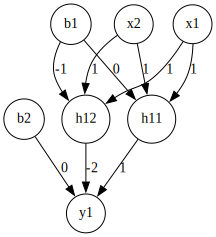

In [18]:
print("=============================================")
print("        FEED FORWARD NEURAL NETWORK")
print("=============================================")
filename = input("Input filename inside test folder: ")

path = "../test/"
model = Reader.read_ffnn(path + filename)

ffnn = FFNN(model=model)
ffnn.compute()
ffnn.predict()

filename = filename.split(".")[0]
graph = Graph(ffnn, filename)

print("=============================================")
print("Graph is saved in folder res with name: " +
      filename + "_graph.png")
print("=============================================")
graph.draw()